**Importing libraries**

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

%matplotlib inline

**Merging Tables**

In [2]:
df = pd.read_csv("data/all_transactions.csv")
df2 = pd.read_csv("data/users.csv")
data = pd.merge(df2, df, on='user_id')

**Extracting Features**

In [3]:
data = data.rename(columns={"created_date_x": "user_created_date", "created_date_y": "transaction_created_date", "country": "user_country"})

In [4]:
data = data[data.transactions_state == 'COMPLETED']

In [5]:
churn_df = data.groupby(['user_id']).agg({'user_created_date': 'first', 'amount_usd': ['sum', 'mean'], 'transaction_created_date': ['count', 'min', 'max']}).reset_index()
churn_df

user_id           user_created_date amount_usd             \
                                       first        sum       mean   
0         user_0  2018-09-10 18:46:42.843855    6925.08  13.317462   
1         user_1  2018-01-11 18:53:10.531146   12955.54  97.410075   
2        user_10  2018-01-26 18:40:43.166413    5438.92  44.218862   
3       user_100  2018-12-02 14:18:09.034151    4230.10  76.910909   
4      user_1000  2018-03-22 22:08:56.267644     843.12  19.607442   
...          ...                         ...        ...        ...   
14816  user_9995  2018-06-05 06:16:51.861843     239.85  59.962500   
14817  user_9996  2018-10-26 03:59:55.030756    1681.76  54.250323   
14818  user_9997  2018-08-18 04:07:31.402857    7650.53  59.769766   
14819  user_9998  2019-01-02 02:17:00.962571     520.72  17.357333   
14820  user_9999  2018-12-17 21:00:16.518284       8.51   8.510000   

      transaction_created_date                              \
                         count                         min   
0                          520  2018-09-10 18:54:08.965855   
1                          133  2018-02-04 08:28:17.978146   
2                          123  2018-06-29 15:38:15.855413   
3                           55  2018-12-02 14:23:12.926151   
4                           43  2019-03-27 11:03:23.105644   
...                        ...                         ...   
14816                        4  2018-06-16 21:35:05.432843   
14817                       31  2018-10-26 04:02:59.274756   
14818                      128  2018-08-18 04:16:07.898857   
14819                       30  2019-01-02 02:23:55.628571   
14820                        1  2019-05-10 14:07:57.842284   

                                   
                              max  
0      2019-05-10 05:09:13.868855  
1      2019-05-04 02:30:11.492146  
2      2019-05-11 13:07:42.624413  
3      2019-02-24 13:36:50.054151  
4      2019-05-05 19:08:42.183644  
...                           ...  
14816  2019-05-01 12:21:34.372843  
14817  2019-01-08 05:59:32.103756  
14818  2019-04-27 00:32:53.447857  
14819  2019-03-15 09:27:13.108571  
14820  2019-05-10 14:07:57.842284  

[14821 rows x 7 columns]

In [6]:
# Calculating how many days since First Transaction
churn_df['first_transaction_date'] = pd.to_datetime(churn_df.transaction_created_date['min'])
churn_df['last_transaction_date'] = pd.to_datetime(churn_df.transaction_created_date['max'])

delta = churn_df['last_transaction_date'] - churn_df['first_transaction_date']
churn_df['Days_Since_First_Transaction'] = delta.dt.days.astype(int)

In [7]:
# Calculating how many days since Last Transaction (since user was Inactive)

last_day = max(churn_df.last_transaction_date)
delta = last_day - churn_df['last_transaction_date']
churn_df['Days_Since_Last_Transaction'] = delta.dt.days.astype(int)

In [8]:
# Calculating how many days since user was Active

churn_df['users_created_date'] = pd.to_datetime(churn_df.user_created_date['first'])

delta = churn_df['last_transaction_date']-churn_df['users_created_date']
churn_df['Days_User_is_active'] = delta.dt.days.astype(int)

In [9]:
churn_df['total_amount'] = churn_df.amount_usd['sum']
churn_df['average_amount'] = churn_df.amount_usd['mean']
churn_df['n_transactions'] = churn_df.transaction_created_date['count']

In [10]:
churn_df = churn_df[['total_amount', 'average_amount', 'n_transactions', 'Days_User_is_active', 'Days_Since_Last_Transaction', 'Days_Since_First_Transaction']]
churn_df

,total_amount,average_amount,n_transactions,Days_User_is_active,Days_Since_Last_Transaction,Days_Since_First_Transaction
,,,,,,
0,6925.08,13.317462,520,241,5,241
1,12955.54,97.410075,133,477,11,453
2,5438.92,44.218862,123,469,4,315
3,4230.10,76.910909,55,83,80,83
4,843.12,19.607442,43,408,10,39
...,...,...,...,...,...,...
14816,239.85,59.962500,4,330,14,318
14817,1681.76,54.250323,31,74,127,74
14818,7650.53,59.769766,128,251,18,251


**Plots**

In [11]:
churn_df.describe()

,total_amount,average_amount,n_transactions,Days_User_is_active,Days_Since_Last_Transaction,Days_Since_First_Transaction
,,,,,,
count,1.482100e+04,14821.000000,14821.000000,14821.000000,14821.000000,14821.000000
mean,8.342743e+03,91.901838,129.302139,224.789825,72.391404,208.720329
std,4.345605e+04,661.165155,223.860826,131.873468,102.947868,132.626399
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.866400e+02,15.477133,13.000000,134.000000,7.000000,112.000000
50%,2.155300e+03,33.011782,50.000000,220.000000,19.000000,203.000000
75%,6.928310e+03,65.704306,144.000000,328.000000,101.000000,311.000000
max,3.206683e+06,53388.961875,2995.000000,493.000000,496.000000,493.000000


(array([1.4806e+04, 8.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0.       ,  5338.8961875, 10677.792375 , 16016.6885625,
        21355.58475  , 26694.4809375, 32033.377125 , 37372.2733125,
        42711.1695   , 48050.0656875, 53388.961875 ]),
 <a list of 10 Patch objects>)

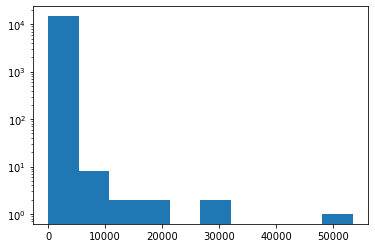

In [12]:
# Average spend per customer

plt.hist(churn_df.average_amount, log=True)

(array([1.4801e+04, 1.3000e+01, 1.0000e+00, 3.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([      0.   ,  320668.297,  641336.594,  962004.891, 1282673.188,
        1603341.485, 1924009.782, 2244678.079, 2565346.376, 2886014.673,
        3206682.97 ]),
 <a list of 10 Patch objects>)

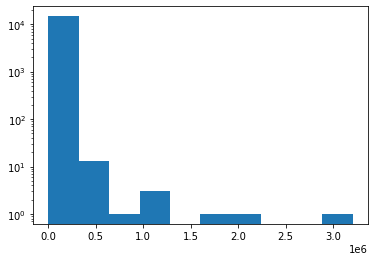

In [13]:
# Total spend per customer

plt.hist(churn_df.total_amount, log=True)

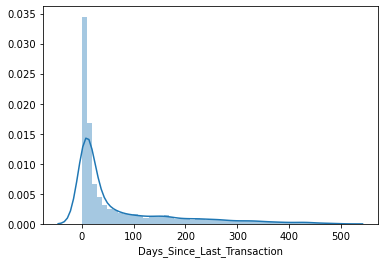

In [14]:
# Distribution of days since last transcation

sns.distplot(churn_df.Days_Since_Last_Transaction)

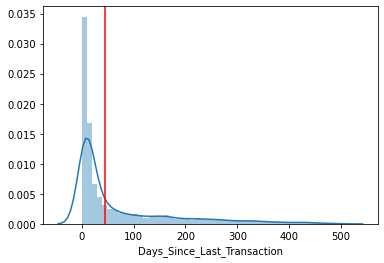

In [46]:
# Distribution of days since last transcation, users with more than

sns.distplot(churn_df.Days_Since_Last_Transaction)
plt.axvline(45, color='red')

Με βάση το παραπάνω μπορούμε να υποθέσουμε ότι όταν ο χρήστης έχει να κάνει συναλλαγή μπορούμε να τον θεωρήσουμε churned. (Long tail/power law distribution)

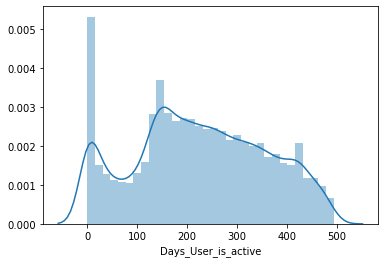

In [16]:
# Distribution of days since creating an acct

sns.distplot(churn_df.Days_User_is_active)

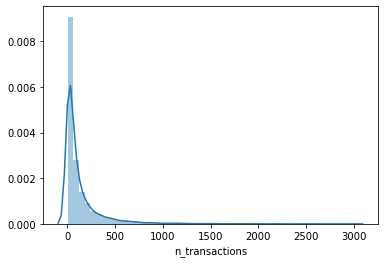

In [17]:
# Distribution of frequency of transcations

sns.distplot(churn_df.n_transactions)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 6 Text major ticklabel objects>)

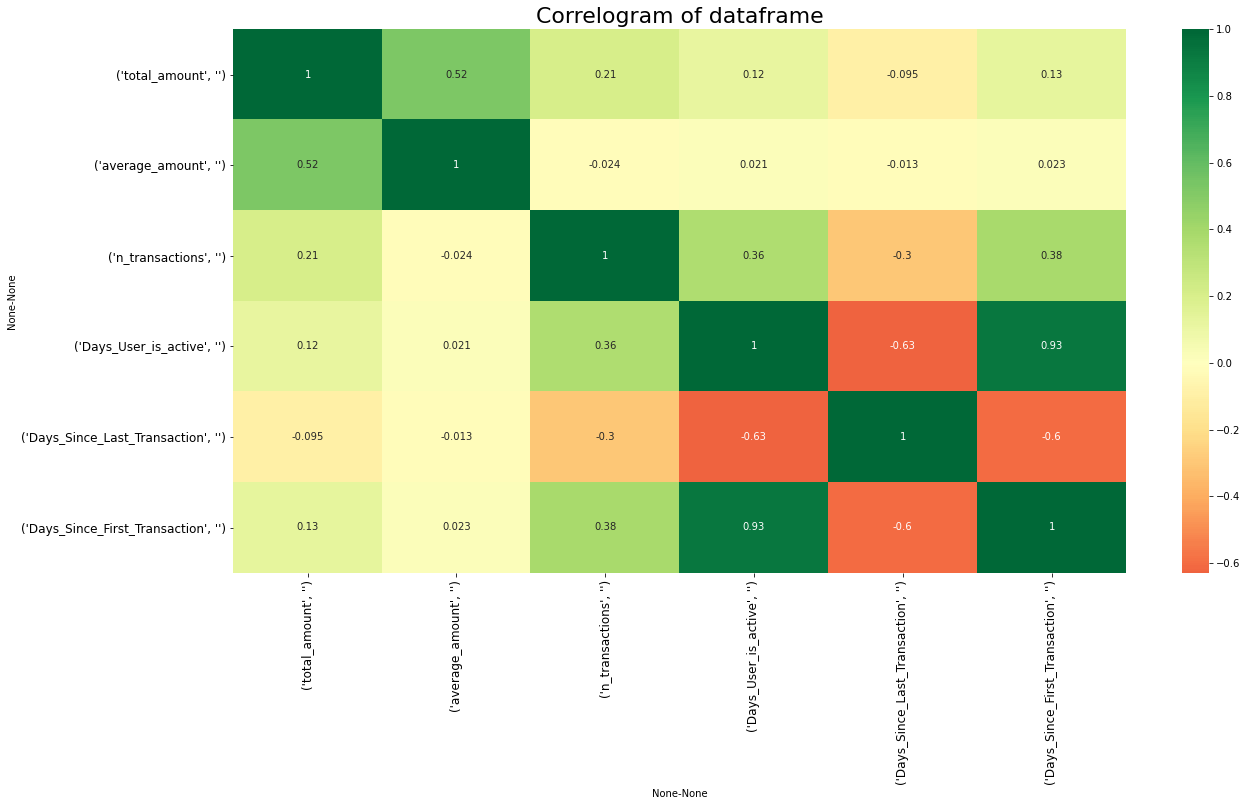

In [18]:
# Plot
plt.figure(figsize=(20,10))
sns.heatmap(churn_df.corr(), xticklabels=churn_df.corr().columns, yticklabels=churn_df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of dataframe', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.show

**Scale data**

In [127]:
churn_df.columns

MultiIndex([(                'total_amount', ''),
            (              'average_amount', ''),
            (              'n_transactions', ''),
            (         'Days_User_is_active', ''),
            ( 'Days_Since_Last_Transaction', ''),
            ('Days_Since_First_Transaction', '')],
           )

In [134]:
scaled_data = preprocessing.normalize(churn_df[['n_transactions', 'Days_User_is_active', 'Days_Since_Last_Transaction', 'Days_Since_First_Transaction']])

**K-Means**

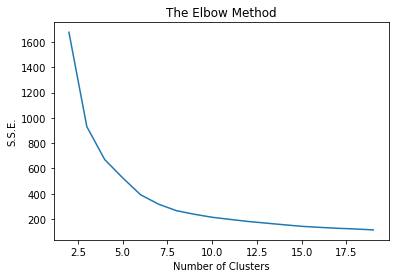

In [139]:
distortions = []
K = range(2, 20)
for k in K:
    kmeansModel = KMeans(n_clusters = k, init = 'k-means++', random_state = 23)
    kmeansModel.fit(scaled_data)
    distortions.append(kmeansModel.inertia_)
    
plt.plot(K, distortions)
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("S.S.E.")
plt.show()

C:\Users\pasca\Anaconda3\envs\pf-ds-thes-team8\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\pasca\Anaconda3\envs\pf-ds-thes-team8\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\pasca\Anaconda3\envs\pf-ds-thes-team8\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\pasca\Anaconda3\envs\pf-ds-thes-team8\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\pasca\Anaconda3\envs\pf-ds-thes-team8\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was

Maximum average silhouette score for k = 2


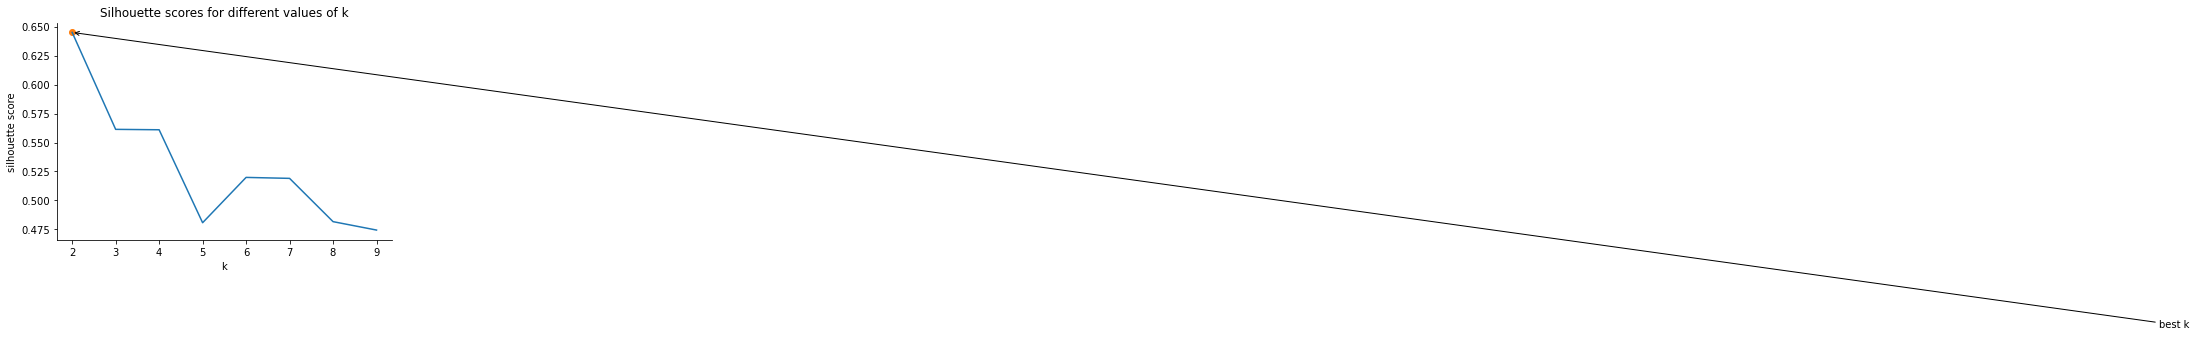

In [140]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 10):
    km = KMeans(k, init = 'k-means++', random_state = 23, n_jobs=-1)
    km.fit(scaled_data)
    preds = km.predict(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, preds))

#                                                PLOTTING:
#                              --------------------------------------------

# Find out the value of k which produced the best silhouette score
best_k = np.argmax(silhouette_scores) + 2  # +2 because range() begins from k=2 

# Create figure
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

# Draw figures
ax.plot(range(2, 10), silhouette_scores)
ax.scatter(best_k, silhouette_scores[best_k-2], color='#ff7f0e') 
ax.annotate("best k", xy=(best_k, silhouette_scores[best_k-2]), xytext=(50, 0.39), arrowprops=dict(arrowstyle="->"))

# Aesthetic parameters
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_title('Silhouette scores for different values of k')

print('Maximum average silhouette score for k =', best_k)

In [141]:
kmeansModel = KMeans(n_clusters = 2, init = 'k-means++', random_state = 23)
kmeansModel.fit(scaled_data)

KMeans(n_clusters=2, random_state=23)

In [91]:
churn_df.columns

MultiIndex([(                'total_amount', ''),
            (              'average_amount', ''),
            (              'n_transactions', ''),
            (         'Days_User_is_active', ''),
            ( 'Days_Since_Last_Transaction', ''),
            ('Days_Since_First_Transaction', '')],
           )

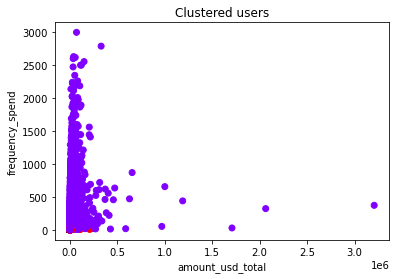

In [142]:
plt.scatter(churn_df.total_amount, churn_df.n_transactions, c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("amount_usd_total")
plt.ylabel("frequency_spend")
plt.show()

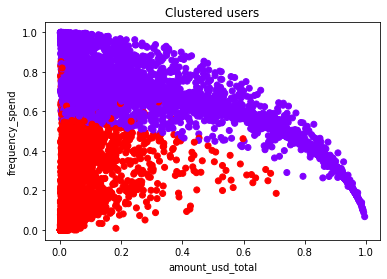

In [143]:
plt.scatter(scaled_data[:,0], scaled_data[:,1], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("amount_usd_total")
plt.ylabel("frequency_spend")
plt.show()

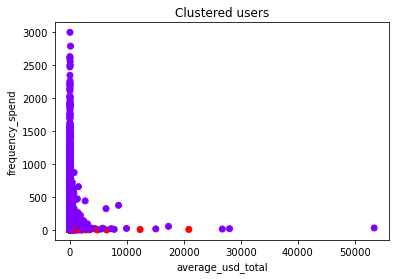

In [144]:
plt.scatter(churn_df.average_amount, churn_df.n_transactions, c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("average_usd_total")
plt.ylabel("frequency_spend")
plt.show()

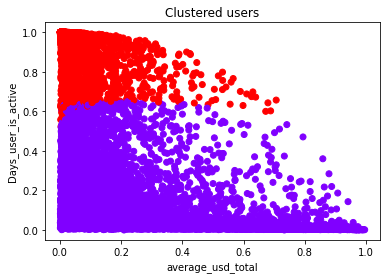

In [145]:
plt.scatter(scaled_data[:,0], scaled_data[:,2], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("average_usd_total")
plt.ylabel("Days_user_is_active")
plt.show()

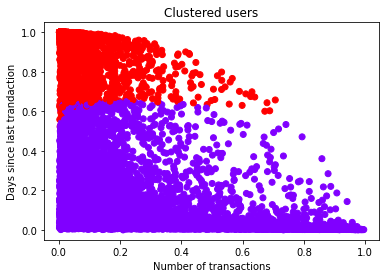

In [146]:
plt.scatter(scaled_data[:,0], scaled_data[:,2], c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("Number of transactions")
plt.ylabel("Days since last trandaction")
plt.show()

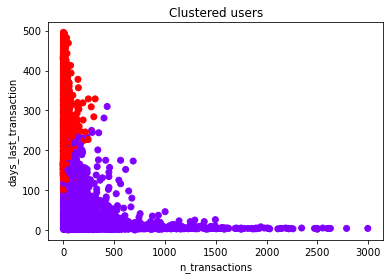

In [147]:
plt.scatter(churn_df.n_transactions, churn_df.Days_Since_Last_Transaction, c=kmeansModel.labels_, cmap='rainbow')
plt.title("Clustered users")
plt.xlabel("n_transactions")
plt.ylabel("days_last_transaction")
plt.show()